In [1]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F

import math
import time

import skrf
from skrf import Network

import utils

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Grab some data

In [3]:
ROOT_PATH = "/scratch1/04703/sravula/UTAFSDataNew/new_data"
CHIP_NUM = 9

In [4]:
test_net = utils.get_network_from_file(ROOT_PATH, CHIP_NUM)['network']

In [5]:
print("S-parameters shape: ", test_net.s.shape)
print("S-parameters type: ", test_net.s.dtype)

S-parameters shape:  (1000, 4, 4)
S-parameters type:  complex128


In [6]:
N_PORTS = test_net.nports
N_FREQS = test_net.frequency.npoints

print("N_FREQS: ", N_FREQS)
print("N_PORTS: ", N_PORTS)

N_FREQS:  1000
N_PORTS:  4


In [7]:
reciprocity = skrf.network.reciprocity(test_net.s)

EPS_SMALL = 1e-6

IS_RECIPROCAL = False
if np.sum(np.abs(reciprocity)) < EPS_SMALL:
    IS_RECIPROCAL = True
    
print("RECIPROCAL: ", IS_RECIPROCAL)

RECIPROCAL:  True


# Grab a toch tensor from this guy

In [8]:
x_test = utils.network_to_sparams(test_net)

In [9]:
print(x_test.shape)
print(x_test.dtype)

torch.Size([1, 20, 1000])
torch.float32


# Grab the measurements that we will use as our ground truth

In [10]:
MEASUREMENT_SPACING = "equal"
M_GT = 0.1 #The ratio of measurements in our gold standard

KEPT_INDS_GT, MISSING_INDS_GT = utils.get_inds(MEASUREMENT_SPACING, N_FREQS, M_GT)

M_GT = len(KEPT_INDS_GT)

print("Number of Ground Truth Frequency Points: ", N_FREQS)
print("Number of Measurements: ", M_GT)
print("Undersampling Ratio: ", M_GT/N_FREQS)

Number of Ground Truth Frequency Points:  1000
Number of Measurements:  100
Undersampling Ratio:  0.1


In [11]:
y_test = torch.clone(x_test)[:, :, KEPT_INDS_GT]

print("y_test shape: ", y_test.shape)

y_test shape:  torch.Size([1, 20, 100])


In [12]:
z_test = torch.clone(x_test)
z_test[:, :, MISSING_INDS_GT] = 0

print("z_test shape: ", z_test.shape)

z_test shape:  torch.Size([1, 20, 1000])


# Plot the Data and measurements 

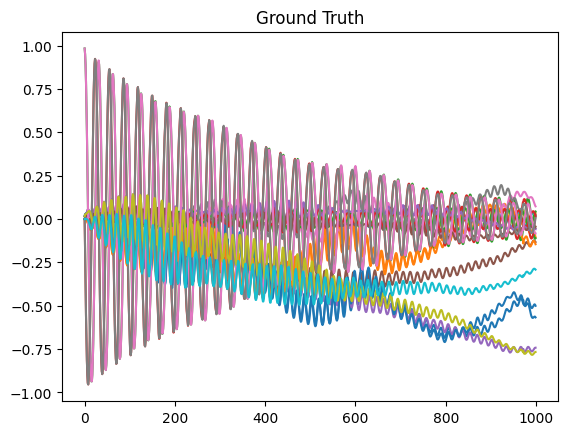

In [13]:
plt.figure()
for i in range(x_test.shape[1]//2):
    plt.plot(x_test[0, 2*i], label=str(i)+" Re")
    plt.plot(x_test[0, 2*i+1], label=str(i)+" Im")
plt.title("Ground Truth")
plt.show()

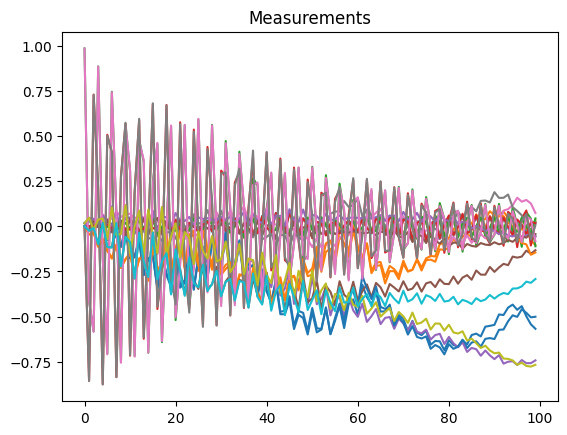

In [14]:
plt.figure()
for i in range(y_test.shape[1]//2):
    plt.plot(y_test[0, 2*i], label=str(i)+" Re")
    plt.plot(y_test[0, 2*i+1], label=str(i)+" Im")
plt.title("Measurements")
plt.show()

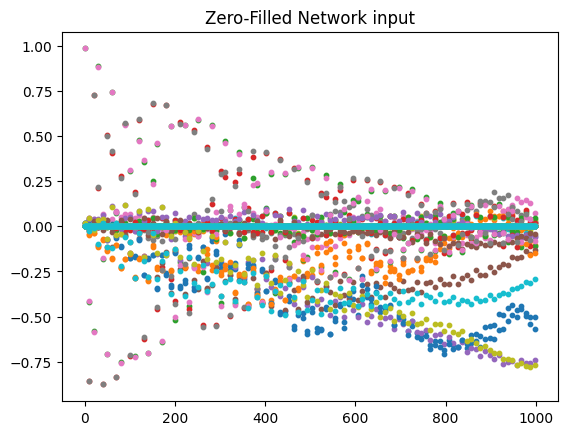

In [15]:
plt.figure()
for i in range(z_test.shape[1]//2):
    plt.scatter(np.arange(z_test.shape[-1]), z_test[0, 2*i], label=str(i)+" Re", s=10)
    plt.scatter(np.arange(z_test.shape[-1]), z_test[0, 2*i+1], label=str(i)+" Im", s=10)
plt.title("Zero-Filled Network input")
plt.show()

# Decide the Pre-Training Parameters

In [16]:
NUM_SCALES = 5
FATHER_SCALES = [1/i for i in range(1, NUM_SCALES+1)][::-1]

print("FATHER_SCALES: ", FATHER_SCALES)

FATHER_SCALES:  [0.2, 0.25, 0.3333333333333333, 0.5, 1.0]


In [17]:
FATHER_SAMPLES = []

for M in FATHER_SCALES:
    if M == 1.0:
        FATHER_SAMPLES.append(y_test)
    else:    
        KEPT_INDS, _ = utils.get_inds(MEASUREMENT_SPACING, M_GT, M)
        FATHER_SAMPLES.append(torch.clone(y_test)[:, :, KEPT_INDS])

torch.Size([1, 20, 20])


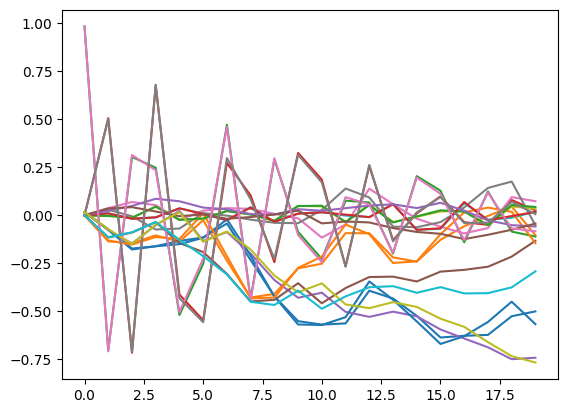

torch.Size([1, 20, 25])


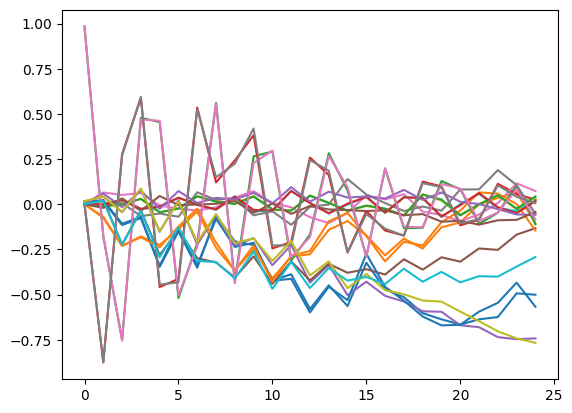

torch.Size([1, 20, 33])


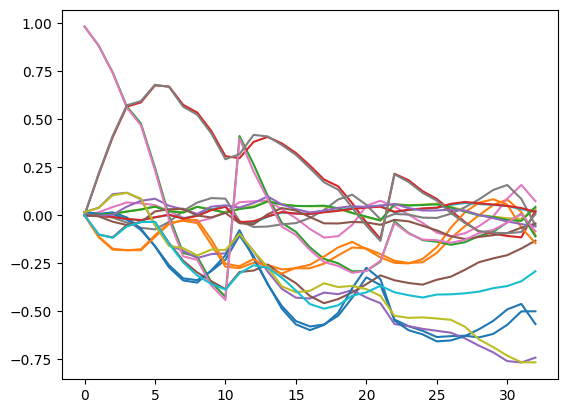

torch.Size([1, 20, 50])


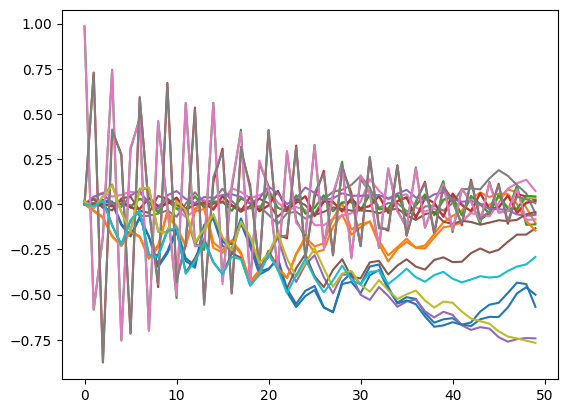

torch.Size([1, 20, 100])


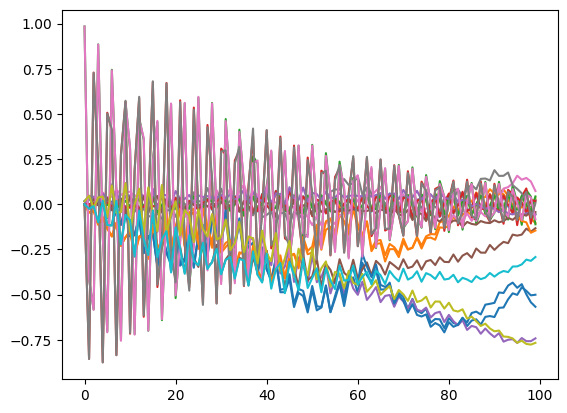

In [18]:
for FATHER in FATHER_SAMPLES:
    print(FATHER.shape)
    
    plt.figure()
    for i in range(FATHER.shape[1]//2):
        plt.plot(FATHER[0, 2*i], label=str(i)+" Re")
        plt.plot(FATHER[0, 2*i+1], label=str(i)+" Im")
    plt.show()

# Define the Augmentations

In [19]:
class Permute_Channels(object):
    """
    Augmentation that takes in a [2*Sparam, N_FREQ] array and returns a version with the S-parameters
        permuted randomly, making sure that pairs of adjacent real/imaginary channels stay together.
    """
    def __init__(self):
        pass
    
    def __call__(self, x):
        n_params = x.shape[-2] // 2 #number of s-parameters
        
        permuted_params = np.random.permutation(n_params) #randomly shuffled list [0...n_params]
        permuted_params = np.repeat(permuted_params, (2)) #repeat each permuted index e.g. [0,2,1]->[0,0,2,2,1,1]
        permuted_params[::2] = permuted_params[::2]*2 #double the even indices
        permuted_params[1::2] = permuted_params[1::2]*2 + 1 #double and offset the odd indices
        
        return x[permuted_params, :] #return a copy of the input with its channels permuted in pairs of re/im

In [20]:
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

class FatherDataset(Dataset):
    def __init__(self, father_samples, noise_sigma=0.01, measurement_spacing="equal", transform=None):
        self.father_samples = [father.clone().squeeze(0) for father in father_samples]
        self.noise_sigma = noise_sigma
        self.measurement_spacing = measurement_spacing
        self.transform = transform
    
    def __len__(self):
        return len(self.father_samples)
    
    def __getitem__(self, idx):
        #(1) grab the proper tensor
        x = self.father_samples[idx]
        if self.transform:
            x = self.transform(x)
        
        len_x = x.shape[-1]
        
        #(2) grab the appropriate measurements from the father
        m = random.uniform(0.1, 0.5) #randomly sample the undersampling factor, with min 2 and max 50% samples
        kept_inds, missing_inds = utils.get_inds(self.measurement_spacing, len_x, m)

        z = torch.clone(x)
        z[:, missing_inds] = 0
        if self.noise_sigma:
            z = z + self.noise_sigma*torch.randn_like(z)
        
        return x, z

# Test a weighted selection of fathers

In [21]:
selection_prob = [np.exp(-1/i) for i in FATHER_SCALES]
sampler = WeightedRandomSampler(selection_prob, 1000, replacement=True)

print(selection_prob)

[0.006737946999085467, 0.01831563888873418, 0.049787068367863944, 0.1353352832366127, 0.36787944117144233]


In [22]:
transform = Permute_Channels()

dataset = FatherDataset(FATHER_SAMPLES, transform = transform)

dataloader = DataLoader(dataset, batch_size=1, sampler=sampler)

In [23]:
lens = {}

for x, _ in dataloader:
    len_x = x.shape[-1]
    if len_x in list(lens.keys()):
        lens[len_x] += 1
    else:
        lens[len_x] = 1

In [24]:
keys = sorted(lens.keys())
for k in keys:
    print(str(k) + ": " + str(lens[k]))

20: 10
25: 37
33: 85
50: 233
100: 635


# Make the network

In [25]:
NC = NZ = y_test.shape[-2]

MIN_LEN = FATHER_SAMPLES[0].shape[-1]
NUM_LAYERS = int(np.ceil(np.log2(MIN_LEN))) - 1

if NZ < 16:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 2) #third power of two after NZ 
elif NZ < 64:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 1) #second power of two after NZ 
elif NZ < 128:
    BASE_NGF = 2 ** int(np.ceil(np.log2(NZ))) #next highest power of 2
else:
    BASE_NGF = NZ

BASE_NGF = 256

KERNEL_SIZE = 3
CAUSAL = True
PASSIVE = False

K = 1 #interpolation factor
NEW_CAUSAL = True

In [26]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("MIN LEN: ", str(MIN_LEN))
print("BASE NGF: ", str(BASE_NGF))
print("NC: ", NC)
print("KERNEL_SIZE: ", KERNEL_SIZE)
print("CAUSAL: ", CAUSAL)
print("PASSIVE: ", PASSIVE)
print("K: ", K)
print("NEW_CAUSAL", NEW_CAUSAL)

NZ:  20
NUM_LAYERS:  4
MIN LEN:  20
BASE NGF:  256
NC:  20
KERNEL_SIZE:  3
CAUSAL:  True
PASSIVE:  False
K:  1
NEW_CAUSAL True


In [27]:
from models import RESNET_BACKBONE, RESNET_HEAD, MODULAR_RESNET

net_backbone = RESNET_BACKBONE(ngf=BASE_NGF,
                               ngf_in_out=BASE_NGF,
                               kernel_size=KERNEL_SIZE,
                               num_layers=NUM_LAYERS)
net_head = RESNET_HEAD(nz=NZ,
                       ngf_in_out=BASE_NGF,
                       nc=NC,
                       # output_size=N_FREQS,
                       kernel_size=KERNEL_SIZE,
                       causal=CAUSAL,
                       passive=PASSIVE,
                       k=K,
                       new_causality=NEW_CAUSAL)

net = MODULAR_RESNET(backbone=net_backbone,
                     head=net_head)
net = net.to(device)

In [28]:
z_temp = torch.randn((1, NZ, MIN_LEN)).to(device)

test_out = net.forward(z_temp)

print("Net output shape: ", test_out.shape)

Net output shape:  torch.Size([1, 20, 20])


In [29]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  5143128


# Define Training Params and Run

In [30]:
LR = 1e-4
NUM_ITERS_PER_RES = [100, 200, 400, 800, 1600]
CUR_FATHERS = []

criterion = nn.MSELoss(reduction="mean")
criterion = criterion.to(device)

optim = torch.optim.Adam(net.parameters(), lr=LR)

loss_list = []

SCALE IDX:  0
NUM ITERS FOR CURRENT SCALE:  100
SELECTION PROB:  [0.006737946999085467]


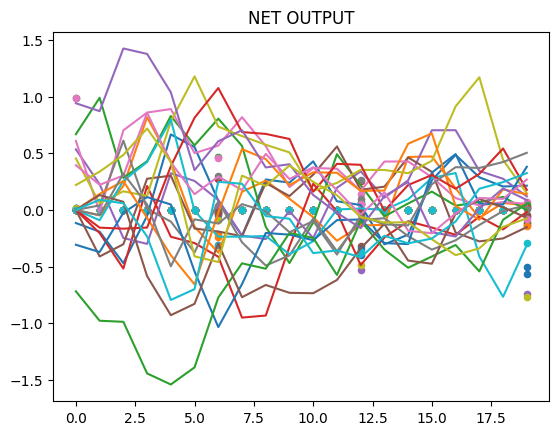

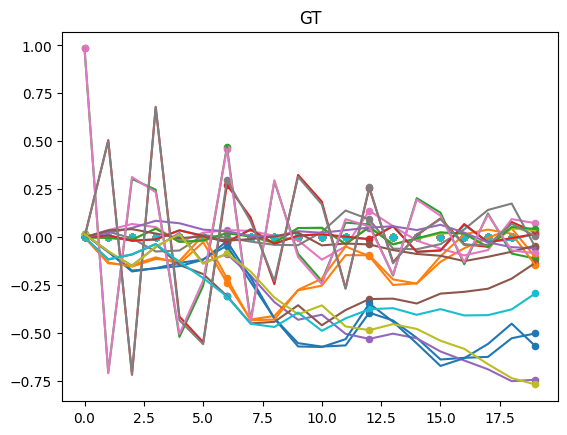

0.26634737849235535
SCALE IDX:  1
NUM ITERS FOR CURRENT SCALE:  200
SELECTION PROB:  [0.006737946999085467, 0.01831563888873418]


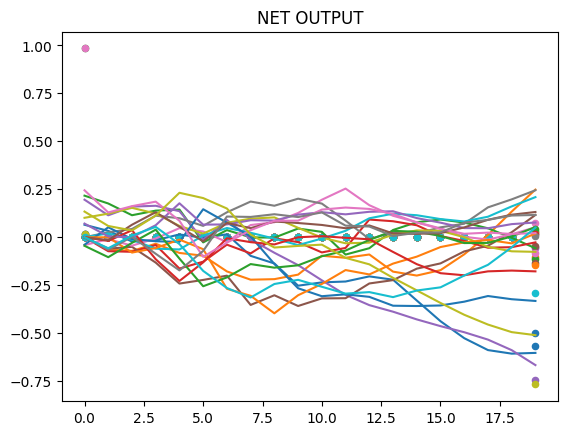

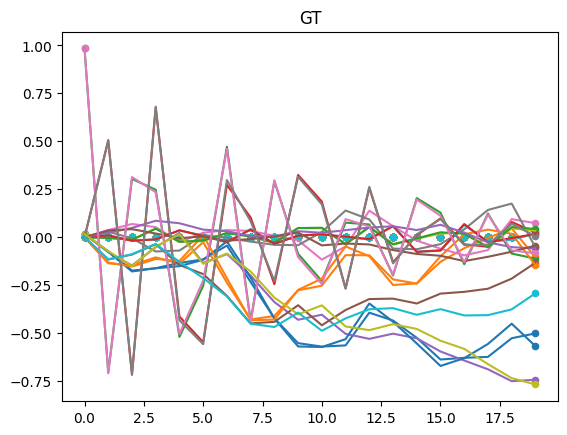

0.07057587005714379
SCALE IDX:  2
NUM ITERS FOR CURRENT SCALE:  400
SELECTION PROB:  [0.006737946999085467, 0.01831563888873418, 0.049787068367863944]


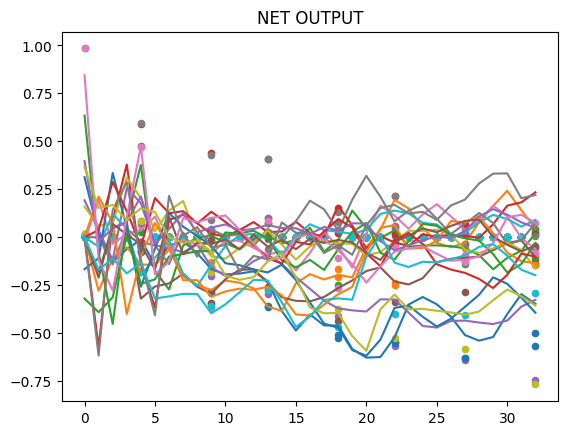

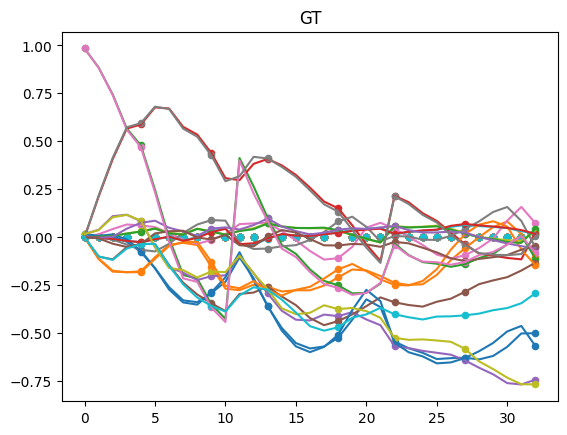

0.042759051837299354
SCALE IDX:  3
NUM ITERS FOR CURRENT SCALE:  800
SELECTION PROB:  [0.006737946999085467, 0.01831563888873418, 0.049787068367863944, 0.1353352832366127]


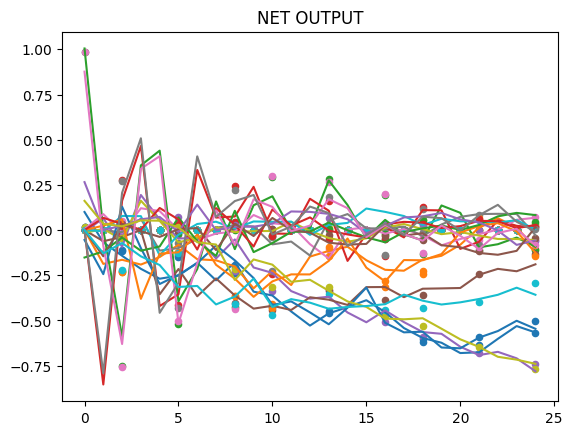

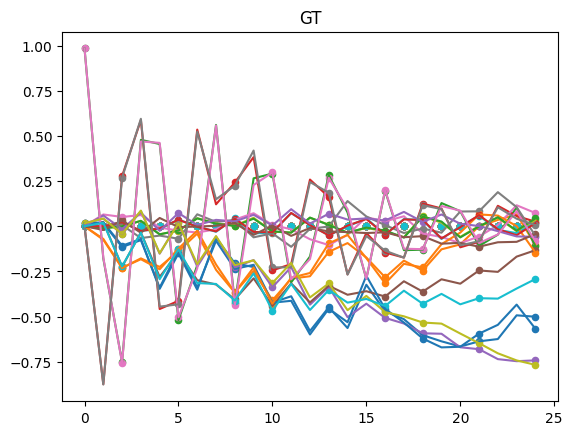

0.031568226744600185


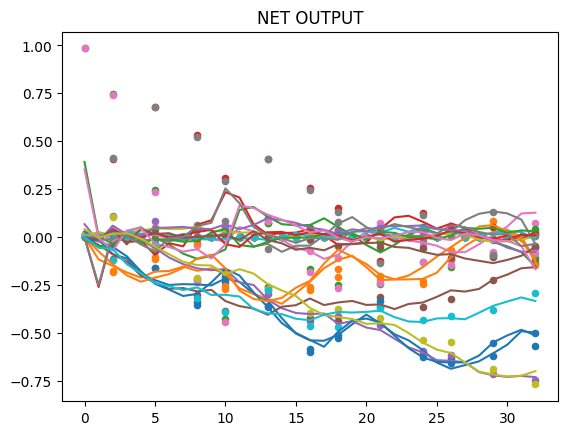

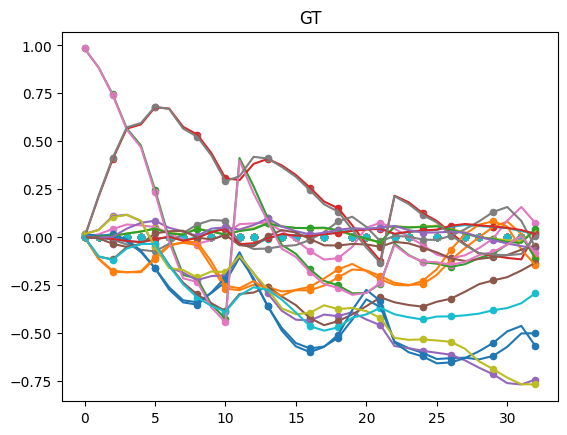

0.028328612874836647
SCALE IDX:  4
NUM ITERS FOR CURRENT SCALE:  1600
SELECTION PROB:  [0.006737946999085467, 0.01831563888873418, 0.049787068367863944, 0.1353352832366127, 0.36787944117144233]


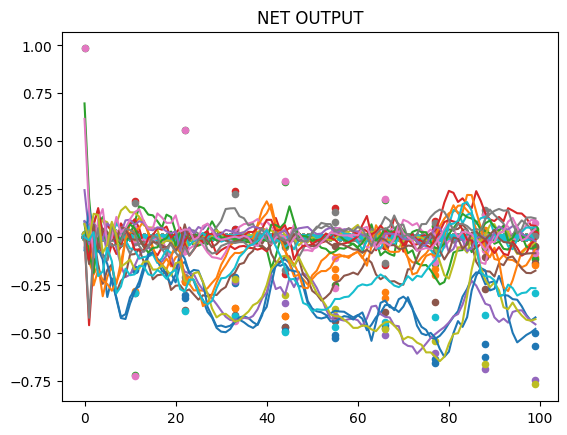

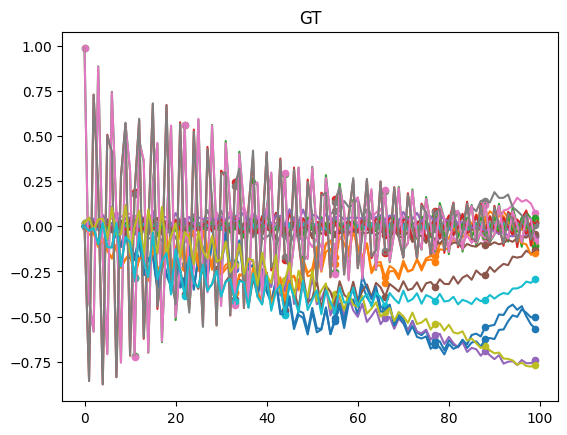

0.027148366377420283


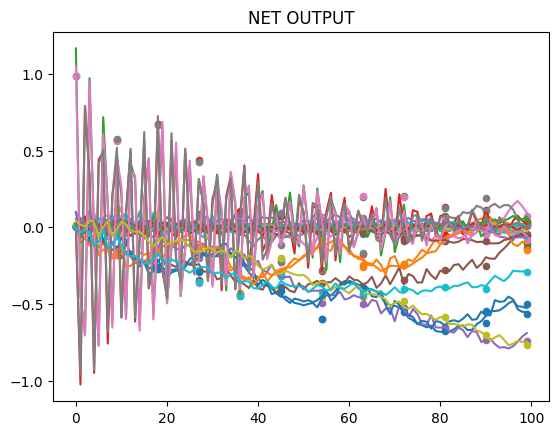

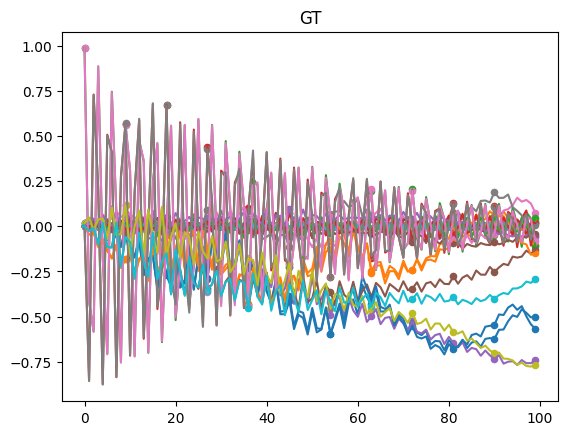

0.023587668457230006


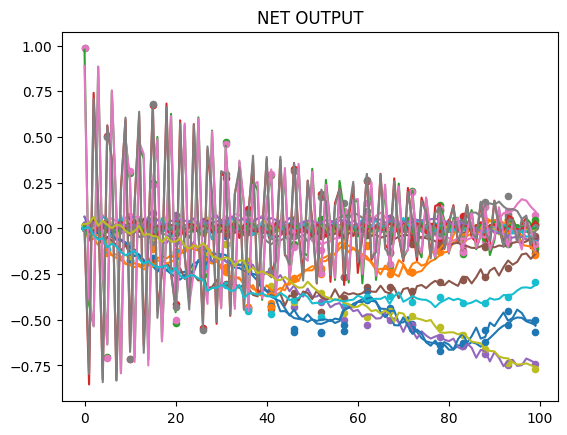

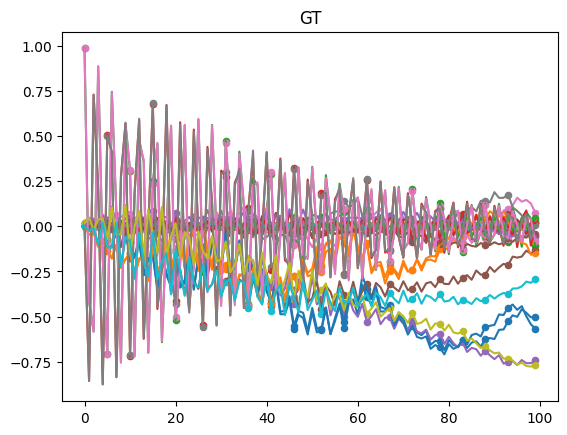

0.020766154291616178


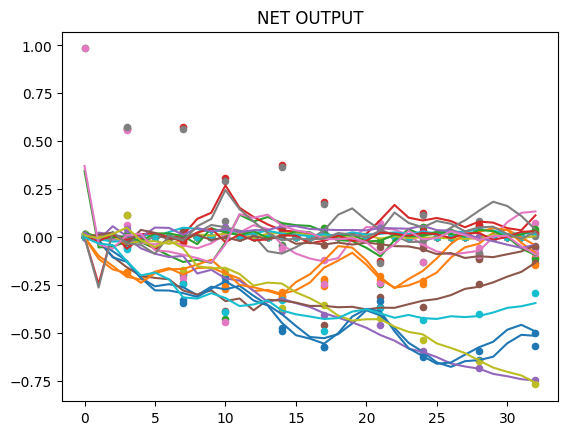

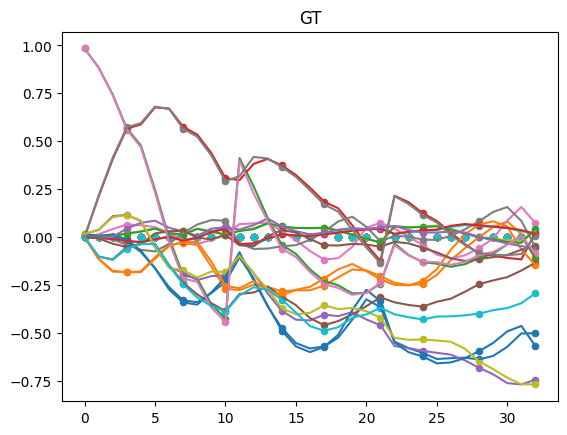

0.018823637150891213


In [31]:
for i in range(NUM_SCALES):
    CUR_FATHERS.append(FATHER_SAMPLES[i])

    selection_prob = [np.exp(-1/l) for l in FATHER_SCALES[0:i+1]]
    sampler = WeightedRandomSampler(selection_prob, NUM_ITERS_PER_RES[i], replacement=True)

    transform = None #Permute_Channels()
    noise_sigma = 0
    dataset = FatherDataset(CUR_FATHERS, transform = transform, noise_sigma=noise_sigma)
    dataloader = DataLoader(dataset, batch_size=1, sampler=sampler)

    print("SCALE IDX: ", i)
    print("NUM ITERS FOR CURRENT SCALE: ", NUM_ITERS_PER_RES[i])
    print("SELECTION PROB: ", selection_prob)
    
    for j, (x, z) in enumerate(dataloader):
        optim.zero_grad()
        
        x = x.to(device)
        z = z.to(device)
        
        out = net.forward(z)
        
        train_loss = criterion(out, x)
        
        train_loss.backward()
        optim.step()
        
        loss_list.append(train_loss.item())
        
        if j%500==0:
            out = out.detach().cpu()
            x = x.detach().cpu()
            z = z.detach().cpu()

            plt.figure()
            for k in range(out.shape[1]//2):
                plt.plot(out[0, 2*k])
                plt.plot(out[0, 2*k+1])
                plt.scatter(np.arange(z.shape[-1]), z[0, 2*k], s=20)
                plt.scatter(np.arange(z.shape[-1]), z[0, 2*k+1], s=20)
            plt.title("NET OUTPUT")
            plt.show()

            plt.figure()
            for k in range(x.shape[1]//2):
                plt.plot(x[0, 2*k])
                plt.plot(x[0, 2*k+1])
                plt.scatter(np.arange(z.shape[-1]), z[0, 2*k], s=20)
                plt.scatter(np.arange(z.shape[-1]), z[0, 2*k+1], s=20)
            plt.title("GT")
            plt.show()

            print(np.mean(loss_list))

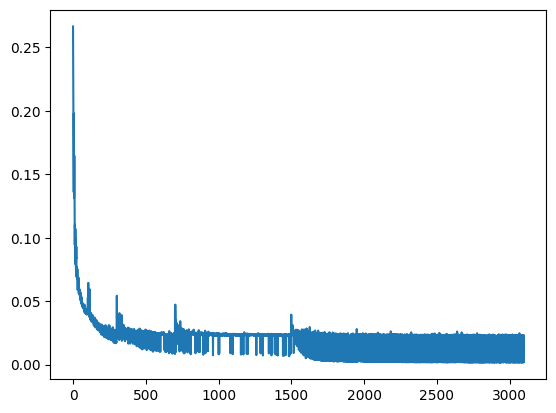

In [32]:
plt.figure()
plt.plot(loss_list)
plt.show()

# Now try on the actual test data

In [33]:
z_test = z_test.to(device)

out = net.forward(z_test)

In [34]:
x_test = x_test.cpu().detach().numpy()
out = out.cpu().detach().numpy()
z_test = z_test.cpu().detach().numpy()

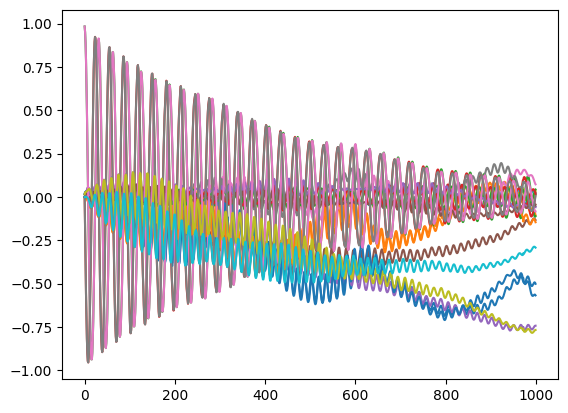

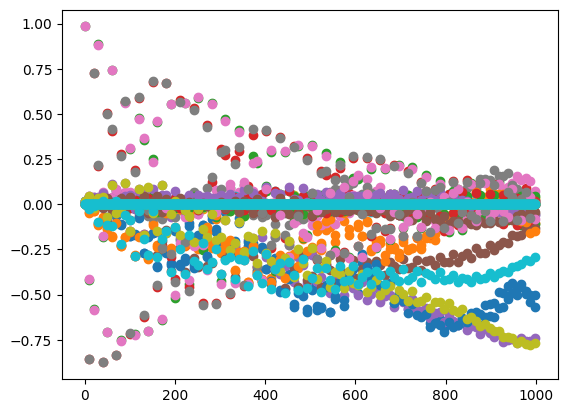

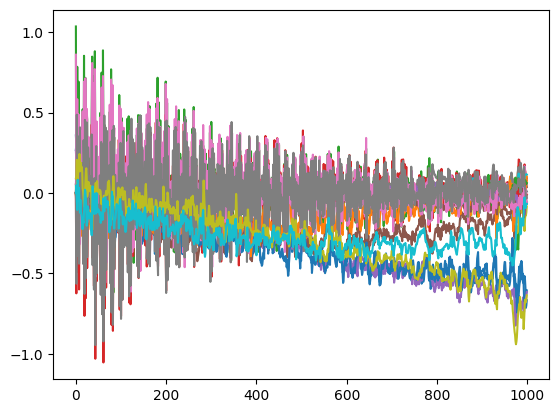

In [35]:
plt.figure()
for i in range(x_test.shape[1]//2):
    plt.plot(x_test[0, 2*i])
    plt.plot(x_test[0, 2*i+1])
plt.show()

plt.figure()
for i in range(z_test.shape[1]//2):
    plt.scatter(np.arange(z_test.shape[-1]), z_test[0, 2*i])
    plt.scatter(np.arange(z_test.shape[-1]), z_test[0, 2*i+1])
plt.show()

plt.figure()
for i in range(out.shape[1]//2):
    plt.plot(out[0, 2*i])
    plt.plot(out[0, 2*i+1])
plt.show()